### Proposal Report : Power Price Prediction

### Executive Summary 

Our proposed business solution aims to improve the accuracy of the power price prediction for Alberta province which is published by Alberta Electric System Operator(AESO) by developing a scalable data science product deployed on the cloud. This product will forecast the hourly energy price 12 hours in advance along with confidence intervals and will also address the lack of interpretability and explainability in the current system. This product will be accompanied by an intuitive tableau dashboard showcasing relevant visualizations to enable stakeholders to monitor real-time hourly predictions with a margin of error.

### Introduction

Over the past few decades, the electricity markets have transformed from regulated to competitive and deregulated. Alberta's electricity market started deregulating in 1996, resulting in highly volatile and uncertain power prices. Many organizations purchase large quantities of energy on demand and rely on energy forecasts to determine their costs in advance. Power price prediction can also be critical for many power generation companies to make effective decisions toward maximizing their profit, like scheduling technical maintenance periods and determining pricing strategies in the market.
The current energy forecasts only provide a short-term coverage of 6-7 hours, which is volatile and lacks interpretation or model visibility. To reduce their expenses, companies could plan and potentially explore alternative energy options if they have access to accurate forecasts which covers a longer window and is also interpretable and explainable. This project aims to help businesses by providing cost analysis and forecasting hourly energy prices 12 hours in advance. Our objective is to empower companies to plan for alternative energy solutions, such as sourcing energy from elsewhere, purchasing at different times, or even developing their own energy systems. The project outcome could also benefit governmental entities and regulators, enabling them to monitor the market and ensure a safe and reliable electricity supply.

The project aims to deliver three products: a model pipeline, a dashboard, and a comprehensive report. The model pipeline will be designed to automate the flow of tasks that includes data wrangling, exploratory data analysis, feature engineering, modeling, and forecasting seamlessly. The dashboard will showcase real-time market price predictions and data visualizations that are interactive and informative for the audience. The report will document information about the electricity market mechanism in Alberta, along with an extensive overview of the modeling strategies and evaluation metrics that were used.



### Data Science Techniques

AESO is an operator service in Alberta that is responsible for managing the power distribution system for the province. This organization publishes relevant data which is used for the computation of market pool price excluding some sensitive information. They also published APIs using which we can access near to real-time data (uptil 1 hour ago) programmatically like price, internal load, etc. However, the values of some of the features are not available in real time which needs to be analyzed based on the historical data alone. Hence the primary sources of data would be the open-source datasets and the APIs. The current datasets contain ~72,000 rows and ~50 features spanning from 2015 – 2023. The main target that we are forecasting 12 hours in advance is the **power pool price** (CAD) which is the balanced average power price for the Alberta province which is finalized by AESO based on the supply and demand. It is capped between 0 and 1000 to ensure that the price is not fluctuating and the Alberta electricity market is stable. Some of the main features that could have a significant impact on the price prediction are given below –

- **Alberta Internal Load** - This feature represents the total amount of power load demand within Alberta. The unit of AIL is MegaWatts (MW).
 - **Hourly Profile** - A categorical variable with two values OFF PEAK and ON PEAK. This indicates whether there is a high/low demand for power at the given hour.
- **Region-wise system load** - This represents the total electric power that is distributed to consumers in Alberta in various regions. Alberta is divided into six regions - Calgary, Edmonton, Central, Northeast, South, and Northwest.
- **Season** - A categorical variable of two values - SUMMER and WINTER. This indicates the season that the given hour belongs to.

There are some additional features that we may include in the later iterative stages like power generation and weather data to understand the difference in prices in various regions in Alberta. The stakeholders would be the power buyers or any other industry clients who are interested in making informed decisions about their energy purchases. This product will assist organizations to plan for alternative power source options like generating power on their own on their site. The metrics used in this project will be useful for them to evaluate the performance of the forecasting model.

We are addressing a supervised learning problem where the objective is to predict market prices based on various features. Given that the data is in time-series format, we will explore the individual features using time-series techniques such as time-series decomposition to study trends and seasonality, and PACF/ACF to identify any autocorrelation or moving average attributes.

Our client considers over-prediction and under-prediction equally harmful, and therefore, we will consider Root Mean Square Error (RMSE) as our evaluation metric, which is commonly used in stock market price prediction and treats both types of errors equally.

To predict market prices, our initial approach could be fitting a univariate time-series ARIMA model of the pool price to estimate the price for the next 12 hours. Another approach could be a two-step forecasting method, where we will use Naïve time series models like ETS to forecast the input features for the next 12 hours. Subsequently, we will use the predicted input features to forecast the price using regression models such as a random forest regression, which could serve as the baseline model.

Alternatively, we could try using a one-step forecasting approach where we predict the future price directly using past values of input features and target price. We can start by fitting a random forest regression model, where the predictors would be the previous 24-hour data of all input features and price.

Since our client prioritizes interpretability over accuracy, we will focus on models that are easy to interpret. Our objective is to extend the forecasting window from 6 hours to 12 hours while maintaining interpretability as our success criterion.


### Exploratory Data Analysis

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import warnings
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "lines.linewidth": 2})

df = pd.read_csv('data/ail_price.csv', parse_dates=['date'], index_col='date')
df = df.sort_values(by='date')

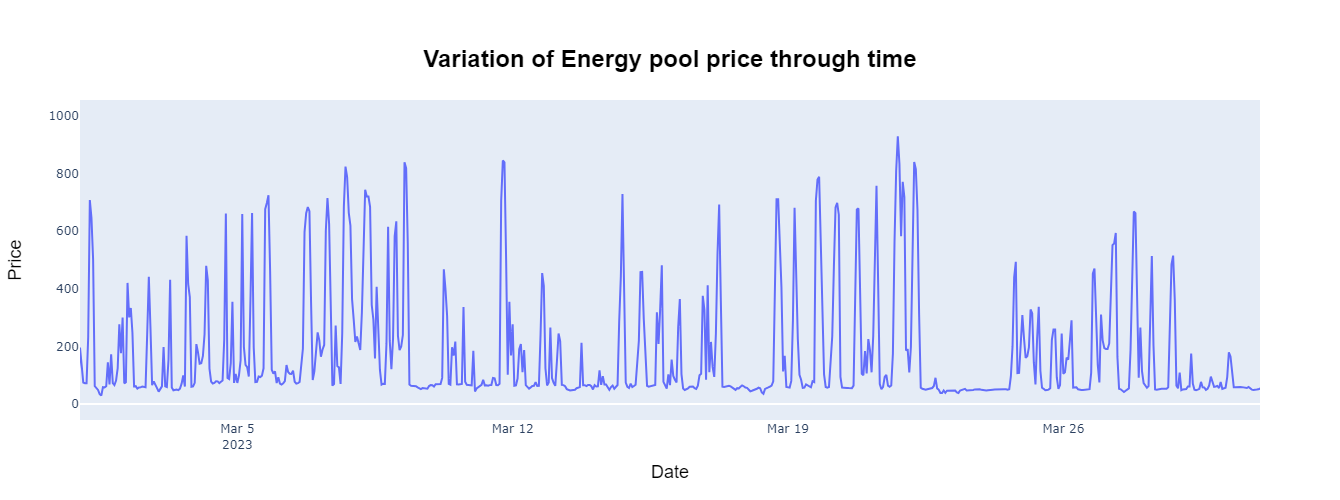

In [12]:
import plotly.graph_objs as go

# Create an interactive plot for the target variable
fig = go.Figure()

trace = go.Scatter(x=df.index, y=df['price'], name='Price', mode='lines')
fig.add_trace(trace)


# Set x-axis range to focus on March 2023
fig.update_layout(title={'text': "<b>Variation of Energy pool price through time</b>", 'font': {'size': 24, 'family': 'Arial', 'color': 'black'}, 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'})


fig.update_layout(
                  xaxis_title={
                        'text': "Date",
                        'font': {
                            'size': 18,
                            'family': 'Arial',
                            'color': 'black'
                        }
                    },
                  yaxis_title={
                        'text': "Price",
                        'font': {
                            'size': 18,
                            'family': 'Arial',
                            'color': 'black'
                        }
                    },
                  xaxis_range=['2023-03-01', '2023-03-31'],height=500,
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False) )

fig.show()


**Plot 1: Variation of Energy pool price through time** This interactive plot shows the variation of Energy pool price through time for March 2023. To see the pattern of time series of prices over the years from 2015 to 2023, click on the `Autoscale` option and `Reset axes` to go back to the focused view.

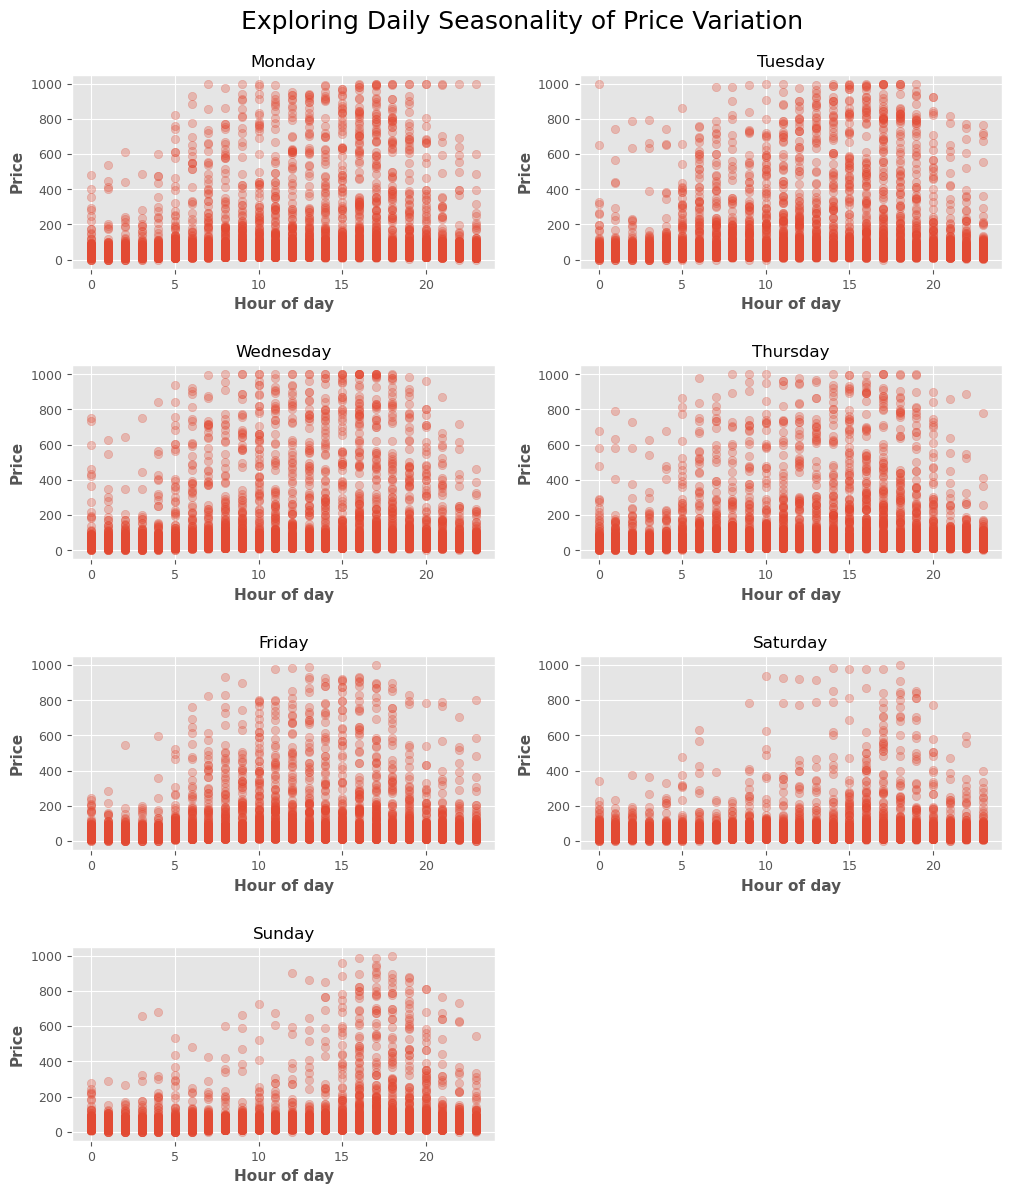

In [16]:
import matplotlib.pyplot as plt

# Define data and plot settings
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 13))
plt.subplots_adjust(hspace=0.5, top=0.93)

# Loop through days of the week and plot data
for i, ax in enumerate(axs.flat):
    if i > 6:
        break

    day = df[df.index.dayofweek == i]
    ax.scatter(day.index.hour, day['price'], alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.set_xlabel('Hour of day', fontsize=11)
    ax.set_ylabel('Price', fontsize=11)
    ax.set_title(f'{day.index[0].strftime("%A")}', fontsize=12)
    
# Add overall title
fig.suptitle('Exploring Daily Seasonality of Price Variation', fontsize=18)

# Remove empty subplot
plt.delaxes(axs[3][1])

# Show plot
plt.show()


**Plot 2: Exploring Daily Seasonality of Price Variation** These daily plots showcases the daily seasonality pattern in the energy prices. We can see that there is a daily seasonality for weekdays where the power prices are higher during working hours and lower off working hours. Similarly, there was a seasonality on the weekends where the power prices were higher during the evenings. This behaviour is confirmed as seen in the autocorrelation function plots where there is a clear daily seasonality as shown below.

<Figure size 1000x800 with 0 Axes>

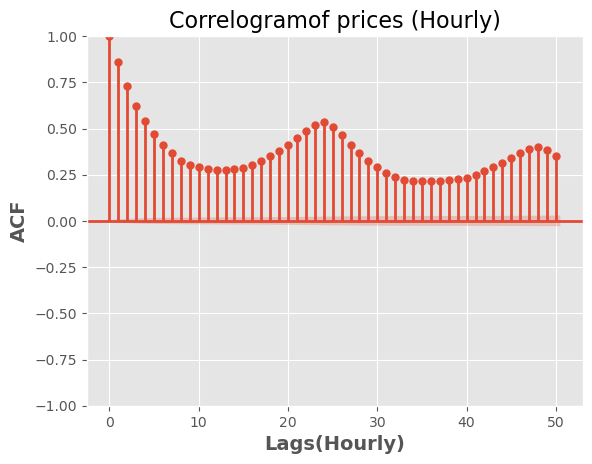

In [21]:
fig = plt.figure(figsize=(10, 8))

# ACF plot
plot_acf(df['price'], lags=50)
plt.title('Correlogram of prices (Hourly)', fontsize=16)
plt.xlabel('Lags(Hourly)', fontsize=14)
plt.ylabel('ACF', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.show()

**Plot 3: Correlogram of prices (Hourly)** This is an autocorrelation function (ACF) plot with 50 lags for the pool price. We can clearly see a daily seasonality in this plot. 

## Timeline

The project timeline is designed to ensure timely completion of the deliverables. The first two weeks are allocated for proposal preparation, problem and data understanding, and initial exploratory data analysis. The primary workload will be during the four middle weeks, where the focus will be on feature engineering, model design, testing, and dashboard development. Week 7 is reserved for product deployment, model refinement, bug fixing, and report finalization. Finally, week 8 is for wrapping up the project, final presentation preparation, and ensuring that all deliverables are completed with high quality. 

![Timeline](timeline.png)

## References

https://www.albertamsa.ca/assets/Documents/MSA-State-of-Mkt-Directions-120620.pdf  

[AESO Market Stat Report [3]](https://docs2.cer-rec.gc.ca/ll-eng/llisapi.dll/fetch/2000/90464/90548/140190/3116766/3421803/3422491/3557838/A91733-5_MW_-_MMTP_-_3.0_2017_Annual_Market_Stats_-_A6E0R5.pdf?nodeid=3557720&vernum=-2)  

https://www.aeso.ca/aeso/understanding-electricity-in-alberta/continuing-education/guide-to-understanding-albertas-electricity-market/

http://ets.aeso.ca/  

https://aeso-portal.powerappsportals.com/data-portal-dashboard/

https://www.aeso.ca/assets/Uploads/market-and-system-reporting/2022_Annual_Market_Stats_Final.pdf

https://public.tableau.com/app/profile/market.analytics/viz/AnnualStatistics_16161854228350/Introduction

https://api.aeso.ca/web/api/ets